<a href="https://colab.research.google.com/github/IlliaOl/Projects/blob/main/GAN/Face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import torchvision
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Grayscale
from torchvision.io import read_image
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class HumanFacesDataset(Dataset):
  def __init__(self, dataset_dir, train=True):
    self.dataset_dir = dataset_dir
    self.image_names = list(os.listdir(dataset_dir))
    self.train_set_size = int(len(self.image_names)*0.8)
    if train:
      self.image_names = self.image_names[:self.train_set_size]
      self.len = len(self.image_names)
    else:
      self.image_names = self.image_names[self.train_set_size:]
      self.len = len(self.image_names)


  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    image_path = os.path.join(self.dataset_dir, self.image_names[idx])
    image = read_image(image_path)/255
    image = Grayscale()(image)
    return image

In [ ]:
train_dataset = HumanFacesDataset("/content/drive/MyDrive/AI/datasets/ffhq")
test_dataset = HumanFacesDataset("/content/drive/MyDrive/AI/datasets/ffhq", train=False) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


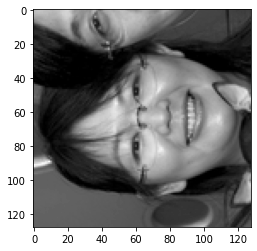

In [ ]:
i = list(train_loader)
i = (i[0][0].T).squeeze()
plt.imshow(i, cmap='gray')

In [ ]:
class HumanGanDiscriminator(nn.Module):
  def __init__(self):
    super(HumanGanDiscriminator, self).__init__()
    self.flatten = nn.Flatten()
    self.model = nn.Sequential(
        nn.Linear(16384, 752),
        nn.ReLU(),
        nn.Linear(752, 128),
        nn.ReLU(),
        nn.Linear(128, 1),        
    )

  def forward(self, x):
    x = self.flatten(x)
    output = self.model(x)
    return output



In [ ]:
class HumanGanGenerator(nn.Module):
  def __init__(self):
    super(HumanGanGenerator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 752),
        nn.ReLU(),
        nn.Linear(752, 16384),
    )

  def forward(self, x):
    output = self.model(x)
    output = output.view(-1, 1, 128, 128)
    return output

In [ ]:
learning_rate = 1e-3
epochs = 100
batch_size = 64


G = HumanGanGenerator().to(device)
D = HumanGanDiscriminator().to(device)

loss_fn = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(G.parameters(), lr=learning_rate)
d_opt = torch.optim.Adam(D.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
  for batch, real_images in enumerate(train_loader):
    real_images = real_images.to(device)
    noise = torch.randn(real_images.shape[0], 128).to(device)
    fake_images = G(noise)
    real_labels = torch.ones(real_images.shape[0], 1).to(device)
    fake_labels = torch.zeros(fake_images.shape[0], 1).to(device)
    real_output = D(real_images)
    fake_output = D(fake_images)
    outputs = torch.cat((real_output, fake_output), 0)
    targets = torch.cat((real_labels, fake_labels), 0)

    d_loss = loss_fn(outputs, targets)
    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    noise = torch.randn(real_images.shape[0], 128).to(device)
    fake_images = G(noise)
    fake_labels = torch.ones(real_images.shape[0], 1).to(device)
    fake_output = D(fake_images)
    g_loss = loss_fn(fake_output, fake_labels)
    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

  if epoch % 10 == 0:
    print(f"Epoch {epoch+1}\n-------------------------------")


with torch.no_grad():
      noise = torch.randn(real_images.shape[0], 128).to(device)
      fake = G(noise)
      fake = np.array(fake[0].cpu())
      fake = (fake.T).squeeze()
      plt.imshow((fake*255).astype(np.uint8), cmap='gray')
      print(g_loss.item())
      
          
          
        
            

print("Done!")

    


Epoch 1
-------------------------------
Epoch 11
-------------------------------
Epoch 21
-------------------------------
Epoch 31
-------------------------------
Epoch 41
-------------------------------
Epoch 51
-------------------------------
Epoch 61
-------------------------------
Epoch 71
-------------------------------
Epoch 81
-------------------------------
Epoch 91
-------------------------------
2.054659605026245
Done!
